## **LIbrerías**

In [1]:
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_columns = False

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
import copy

In [54]:
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import confusion_matrix, classification_report

## **Data**

In [26]:
X, y = make_classification(
    n_samples=1200,
    n_features=2,
    n_clusters_per_class=1,
    n_informative=1,
    class_sep=0.5,
    n_redundant=0,
    n_repeated=0,
    random_state=13
)

In [27]:
colors = ['#fe7c73', '#2471A3']

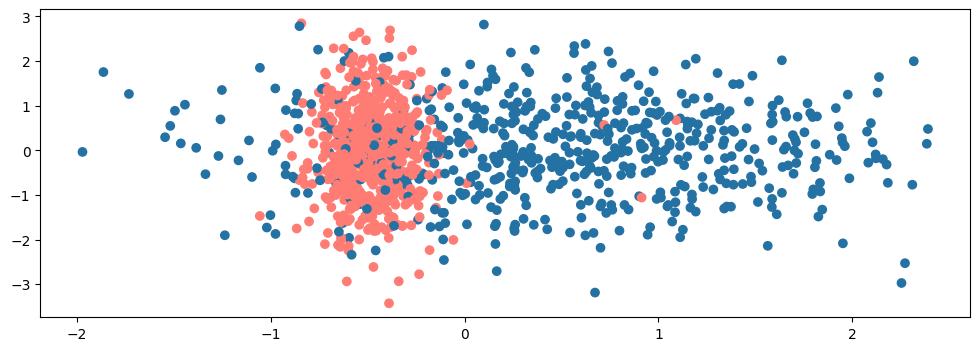

In [29]:
plt.subplots(figsize=(12, 4))

plt.scatter(
    X[:,0], 
    X[:,1],
    c=[colors[i] for i in y]
)

plt.show()

## **Preparación de los datos**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, train_size=0.2)

## **Random Forest - Tradicional**

In [188]:
model_rf = RandomForestClassifier(
    max_features='sqrt',
    max_samples=0.9,
    n_estimators=100,
    random_state=13
)

model_rf.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.9, random_state=13)

In [189]:
model_rf.score(X_test, y_test)

0.88125

In [190]:
y_pred = model_rf.predict(X_test)

In [191]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       480
           1       0.91      0.85      0.88       480

    accuracy                           0.88       960
   macro avg       0.88      0.88      0.88       960
weighted avg       0.88      0.88      0.88       960



<Axes: >

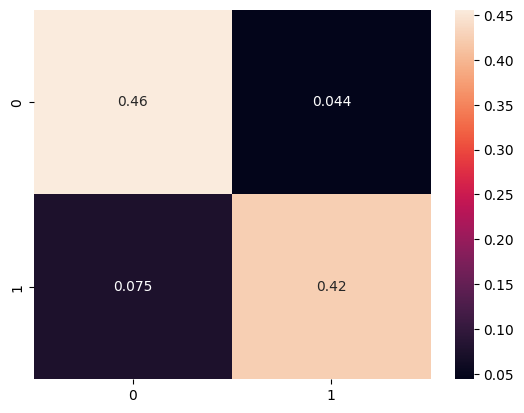

In [192]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred)/len(y_test), annot=True)

## **Random Forest - Mejorado**

In [193]:
# Podemos ver los arboles que toma el modelo 
model_rf.estimators_[:5]

[DecisionTreeClassifier(max_features='sqrt', random_state=1192722770),
 DecisionTreeClassifier(max_features='sqrt', random_state=461027504),
 DecisionTreeClassifier(max_features='sqrt', random_state=1020231754),
 DecisionTreeClassifier(max_features='sqrt', random_state=1543757328),
 DecisionTreeClassifier(max_features='sqrt', random_state=1392765670)]

In [194]:
# Vamos a calcular la precisión de cada uno de nuestros arboles
model_accs = []

for i, tree in enumerate(model_rf.estimators_):
    score = tree.score(X_test, y_test)
    model_accs.append([i, score])

model_accs = np.array(model_accs)

In [195]:
# Organizamos los indices segun el score de cada arbol
sorter_index = np.argsort(model_accs[:, 1])[::-1]

# Traemos los indices de nuestros modelos ordenados por score
model_ids = model_accs[sorter_index][:,0].astype(int)

# Organizamos los arboles dentro de nuestro modelo segun su score
model_rf.estimators_ = np.array(model_rf.estimators_)[model_ids].tolist()

In [196]:
# Ahora los arboles estan organizados por score
model_rf.estimators_[:5]

[DecisionTreeClassifier(max_features='sqrt', random_state=2025473427),
 DecisionTreeClassifier(max_features='sqrt', random_state=1629224066),
 DecisionTreeClassifier(max_features='sqrt', random_state=772441077),
 DecisionTreeClassifier(max_features='sqrt', random_state=1605516543),
 DecisionTreeClassifier(max_features='sqrt', random_state=695407435)]

In [197]:
result = []

# Definimos nuestro total de arboles
total_models = len(model_rf.estimators_)

# Vamos a ir agregando arboles por cada iteración
for i in range(1, total_models):
    # Creamos una copia de nuestro modelo
    small_model = copy.deepcopy(model_rf)

    # Traemos los arboles acumulados hasta i
    small_model.estimators_ = model_rf.estimators_[:i]

    # Agregamos la métrica resultante de los arboles acumulados
    result.append([i, small_model.score(X_test, y_test)])

result = np.array(result)

In [198]:
# Calulamos la cantidad de arboles donde se alcanza el mayor score
max_index = np.argmax(result[:,1])
max_index

7

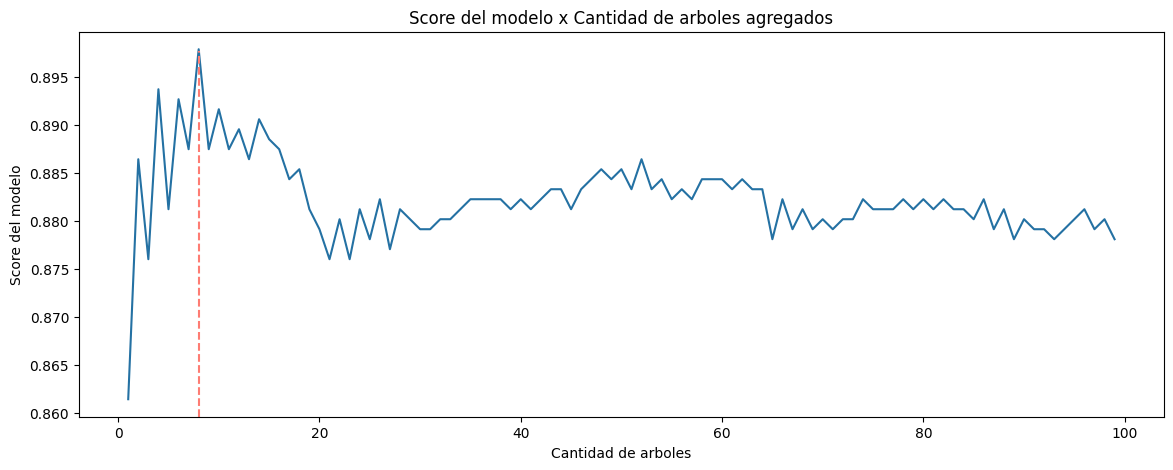

In [199]:
plt.subplots(figsize=(14, 5))

plt.plot(
    result[:, 0],
    result[:, 1],
    c=colors[1]
)

# Determinamos donde se alcanza el mayor score
plt.axvline(
    x=result[max_index][0], 
    ymax=0.95, 
    ls = "--", 
    c=colors[0]
)

plt.title('Score del modelo x Cantidad de arboles agregados')

plt.xlabel('Cantidad de arboles')
plt.ylabel('Score del modelo')

plt.show()

In [200]:
# Copiamos nuestro modelo original
model_improved = copy.deepcopy(model_rf)

In [201]:
# Nos quedamos solo con la cantidad de arboles que maximizan nuestro score
model_improved.estimators_ = model_rf.estimators_[:int(result[max_index][0])]

In [202]:
# Calculamos el score con este nuevo modelo
model_improved.score(X_test, y_test)

0.8979166666666667

In [203]:
y_pred_improved = model_improved.predict(X_test)

In [204]:
print(classification_report(y_pred=y_pred_improved, y_true=y_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       480
           1       0.92      0.87      0.89       480

    accuracy                           0.90       960
   macro avg       0.90      0.90      0.90       960
weighted avg       0.90      0.90      0.90       960



<Axes: >

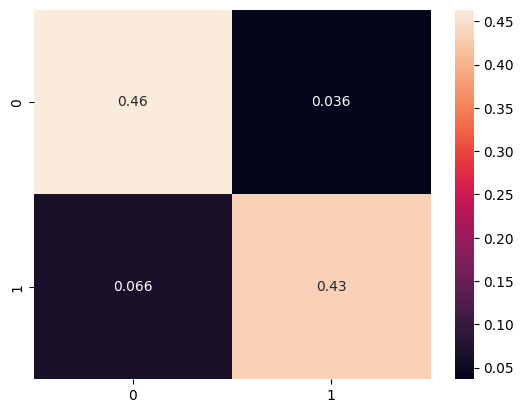

In [205]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_improved)/len(y_test), annot=True)